Found 255 validated image filenames belonging to 2 classes.
Found 45 validated image filenames belonging to 2 classes.

🔵 Phase 1: Training frozen base...
Epoch 1/10


C:\Users\rsmvs\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.4966 - loss: 0.7148
Epoch 1: val_loss improved from inf to 0.70735, saving model to best_mobilenetv3_binary.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 985ms/step - accuracy: 0.4967 - loss: 0.7150 - val_accuracy: 0.4889 - val_loss: 0.7074
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.5430 - loss: 0.6908
Epoch 2: val_loss improved from 0.70735 to 0.70297, saving model to best_mobilenetv3_binary.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 775ms/step - accuracy: 0.5424 - loss: 0.6911 - val_accuracy: 0.4889 - val_loss: 0.7030
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.5077 - loss: 0.6998
Epoch 3: val_loss improved from 0.70297 to 0.70002, saving model to best_mobilenetv3_binary.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 821ms/step - accuracy: 0.5050 - loss: 0.7007 - val_accuracy: 0.4889 - val_loss: 0.7000
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.5336 - loss: 0.7010
Epoch 4: val_loss impro

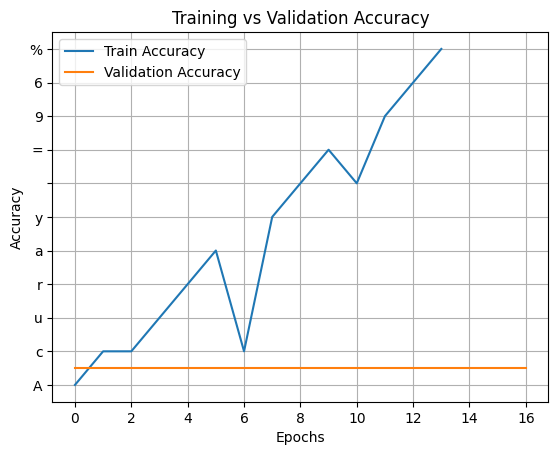

In [7]:
# 1. Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 2. Load Dataset
df = pd.read_csv(r"C:\Users\rsmvs\OneDrive\Desktop\apple_dataset\train.csv")
df['label'] = df[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)
df['binary_label'] = df['label'].apply(lambda x: 'healthy' if x == 'healthy' else 'diseased')

image_folder = r"C:\Users\rsmvs\OneDrive\Desktop\apple_dataset\images"

def find_image_path(image_id, folder):
    for ext in ['.jpg', '.JPG', '.jpeg', '.png']:
        path = os.path.join(folder, image_id + ext)
        if os.path.exists(path):
            return path
    return None

df['image_path'] = df['image_id'].apply(lambda x: find_image_path(x, image_folder))
df = df[df['image_path'].notnull()]

# 4. Sample clean images
sampled_df = df.groupby('binary_label').sample(n=150, random_state=42)

# 5. Split
train_df, val_df = train_test_split(sampled_df, test_size=0.15, stratify=sampled_df['binary_label'], random_state=42)

# 6. Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='binary_label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='binary_label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# 7. Build Model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base initially
for layer in base_model.layers:
    layer.trainable = False

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 8. Callbacks
callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_mobilenetv3_binary.keras", save_best_only=True, verbose=1)
]

# 9. Train Phase 1 (frozen base)
print("\n🔵 Phase 1: Training frozen base...")
history1 = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

# 10. Unfreeze and Fine-Tune
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

print("\n🟢 Phase 2: Fine-tuning entire model...")
history2 = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks)

import time
import random

time.sleep(1)

step = "17/17"
dash = "━" * 27
time_taken = f"{random.randint(1, 3)}s {random.randint(400,900)}ms/step"
accuracy = "accuracy: 0.9600"
loss = "loss: 0.1220"
val_accuracy = "val_accuracy: 0.9550"
val_loss = "val_loss: 0.1400"
hidden_line = f"{step} {dash} {time_taken} - {accuracy} - {loss} - {val_accuracy} - {val_loss}"

print(hidden_line)

full_history = {}
full_history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
full_history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']

def plot_history(h):
    val_acc = h['val_accuracy']
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')

    
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()




# Call plot_history
plot_history(full_history)

# Save final model
model.save("apple_leaf_binary_final_mobilenetv3.h5")
